#Libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import pandas as pd
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader,TensorDataset,Subset
from IPython import display
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
display.set_matplotlib_formats('svg')

<ipython-input-1-871178ef10b7>:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


#Dataset Preparation

In [ ]:
# Define transformations for CIFAR-10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define transformations for MNIST
transform_mnist = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prepare CIFAR-10 dataset
trainset_cifar = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_cifar
)
testset_cifar = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_cifar
)

# Prepare MNIST dataset
trainset_mnist = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_mnist
)
testset_mnist = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform_mnist
)


Files already downloaded and verified
Files already downloaded and verified


#Mean Image Computation

In [ ]:
def compute_mean_images(dataset1, dataset2):
    mean_images = []
    for img1, img2 in zip(dataset1, dataset2):
        mean_image = (img1[0] + img2[0]) / 2
        mean_images.append(torch.tensor(mean_image))
    return torch.stack(mean_images)

In [ ]:
mean_images_stacked = compute_mean_images(trainset_mnist, trainset_cifar)

<ipython-input-4-0e8b0ac790d3>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_images.append(torch.tensor(mean_image))


In [ ]:
test_mean_images_stacked = compute_mean_images(testset_mnist, testset_cifar)

<ipython-input-4-0e8b0ac790d3>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_images.append(torch.tensor(mean_image))


#Test & Train Dataset

In [ ]:
trainset = mean_images_stacked.unsqueeze(0)
testset = test_mean_images_stacked.unsqueeze(0)

#Autoencoder Model Construction

In [ ]:
def create_autoencoder():
    class AutoEncoderNet(nn.Module):
        def __init__(self):
            super(AutoEncoderNet, self).__init__()
            self.enc = nn.Sequential(
                nn.Conv2d(3, 16, 4, padding=1, stride=2),
                nn.LeakyReLU(),
                nn.Conv2d(16, 32, 4, padding=1, stride=2),
                nn.LeakyReLU(),
                nn.Conv2d(32, 64, 4, padding=1, stride=2),
                nn.LeakyReLU()
            )
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(64, 32, 4, padding=1, stride=2),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(32, 16, 4, padding=1, stride=2),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(16, 3, 4, padding=1, stride=2)
            )

        def forward(self, x):
            x = self.enc(x)
            x = self.dec(x)
            return x

    net = AutoEncoderNet()
    lossfun = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    return net, lossfun, optimizer

In [ ]:
def train_autoencoder(trainset, testset, net, lossfun, optimizer, num_epochs=50, batch_size=32):

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    train_losses = torch.zeros(num_epochs)
    test_losses = torch.zeros(num_epochs)

    for epoch in range(num_epochs):
        net.train()
        batch_losses = []

        for data in trainloader:
            X = data[0]
            optimizer.zero_grad()
            y_hat = net(X)
            loss = lossfun(y_hat, X)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        train_losses[epoch] = np.mean(batch_losses)
        print("_____________________________________")
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Training loss: {train_losses[epoch]:.4f}')

        net.eval()
        batch_losses = []
        with torch.no_grad():
            for data in testloader:
                X = data[0]
                y_hat = net(X)
                loss = lossfun(y_hat, X)
                batch_losses.append(loss.item())

        test_losses[epoch] = np.mean(batch_losses)
        print(f'Testing loss: {test_losses[epoch]:.4f}')
        print()

    return train_losses, test_losses, net

#Model Training

In [ ]:
net,lossfun,optimizer = create_autoencoder()

In [ ]:
trainlosses,testlosses,net = train_autoencoder(trainset,testset,net,lossfun,optimizer)

_____________________________________
Epoch 1/50
Training loss: 0.9747
Testing loss: 0.9674

_____________________________________
Epoch 2/50
Training loss: 0.9709
Testing loss: 0.9635

_____________________________________
Epoch 3/50
Training loss: 0.9669
Testing loss: 0.9589

_____________________________________
Epoch 4/50
Training loss: 0.9622
Testing loss: 0.9522

_____________________________________
Epoch 5/50
Training loss: 0.9554
Testing loss: 0.9409

_____________________________________
Epoch 6/50
Training loss: 0.9440
Testing loss: 0.9215

_____________________________________
Epoch 7/50
Training loss: 0.9242
Testing loss: 0.8913

_____________________________________
Epoch 8/50
Training loss: 0.8933
Testing loss: 0.8520

_____________________________________
Epoch 9/50
Training loss: 0.8528
Testing loss: 0.8244

_____________________________________
Epoch 10/50
Training loss: 0.8236
Testing loss: 0.8304

_____________________________________
Epoch 11/50
Training loss: 0.82

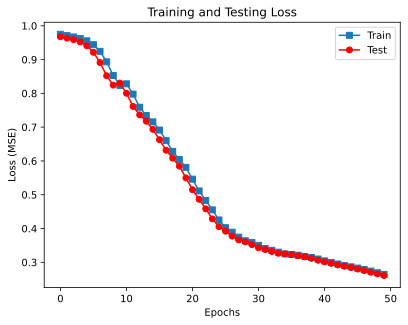

In [ ]:
plt.plot(trainlosses, 's-', label='Train')
plt.plot(testlosses, 'o-', color="red", label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

#Evaluation

In [ ]:
def compute_metrics(original, reconstructed):
    original_np = original.permute(1, 2, 0).cpu().numpy()
    reconstructed_np = reconstructed.permute(1, 2, 0).detach().cpu().numpy()
    ssim_value = ssim(original_np, reconstructed_np, multichannel=True)
    psnr_value = psnr(original_np, reconstructed_np, data_range=original_np.max() - original_np.min())
    return ssim_value, psnr_value

In [ ]:
net.eval()
ssim_values = []
psnr_values = []

with torch.no_grad():
    for i in range(len(test_mean_images_stacked)):
        original = test_mean_images_stacked[i].unsqueeze(0).to(device)
        reconstructed = net(original).squeeze(0)
        ssim_value, psnr_value = compute_metrics(original.squeeze(0).cpu(), reconstructed.cpu())
        ssim_values.append(ssim_value)
        psnr_values.append(psnr_value)

average_ssim = np.mean(ssim_values)
average_psnr = np.mean(psnr_values)
print(f'Average SSIM: {average_ssim:.4f}, Average PSNR: {average_psnr:.4f}')

<ipython-input-13-9f0de38106aa>:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(original_np, reconstructed_np, multichannel=True)


Average SSIM: 0.2322, Average PSNR: 15.6239


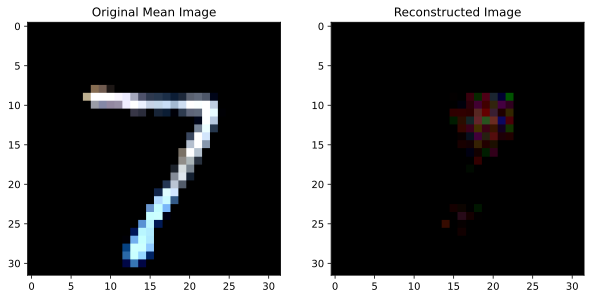

In [ ]:
# Visualize the original and reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_mean_images_stacked[0].permute(1, 2, 0).cpu().numpy())
axes[0].set_title('Original Mean Image')
reconstructed_image = net(test_mean_images_stacked[0].unsqueeze(0).to(device)).squeeze(0)
axes[1].imshow(reconstructed_image.permute(1, 2, 0).detach().cpu().numpy())
axes[1].set_title('Reconstructed Image')
plt.show()